<a href="https://colab.research.google.com/github/TheLemonPig/RL-SSM/blob/main/RL_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install Packages

In [ ]:
# restart runtime after running and skip this cell
!pip install 'pymc>=5.9'
!pip install numpyro

##2. Import Packages

In [1]:
import numpyro
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import functools
from scipy.optimize import curve_fit
import pymc as pm
import arviz as az
from typing import List, Callable
from functools import partial
from tqdm import tqdm

##3. Create Simple RL Model

In [2]:
def softmax(qs, tau):
  safe_tau = np.abs(tau) + 1e-2
  return np.exp(qs/safe_tau) / np.exp(qs/safe_tau).sum()

def rescola(qt, alpha, reward):
  return qt + alpha * (reward - qt)

In [3]:
class Distribution:

  def __init__(self, func: Callable, kwargs):
    self.func: Callable = partial(func, **kwargs)

  def __call__(self):
    return self.func.__call__()

In [4]:
class SimpleRL:

  def __init__(self, n_trials: int, distributions: List[Distribution]):
    self.n_choices: int = len(distributions)
    self.n_trials: int = n_trials
    self.distributions: List[Distribution] = distributions
    self.qs: np.array = np.ones((self.n_choices,)) * 0.5
    self.q_trace: np.array = np.ones((self.n_trials,self.n_choices))
    self.rewards: np.array = np.zeros((self.n_trials))
    self.choices: np.array = np.zeros((self.n_trials),dtype=np.int32)

  def simulate(self, alpha, temperature):
    for i in range(self.n_trials):
      # Q-values are recorded to trace
      self.q_trace[i] = self.qs
      # softmax decision function
      ps = softmax(self.qs,temperature)
      # choice made based on weighted probabilities of Q-values
      choice = np.random.choice(a=self.n_choices,size=1,p=ps)[0]
      # choice is recorded to trace
      self.choices[i] = choice
      # reward calculated
      dist = self.distributions[choice]  # supply a list of distributions to choose from
      reward = dist()  # sample from distribution by calling it
      # Q-values updated
      self.rewards[i] = reward
      self.qs[choice] = rescola(self.qs[choice],alpha,reward)
    # Q-values trace returned
    # main data to be returned (basis for fits), is choices and rewards per trial
    return self.rewards, self.choices

##4. Simulate Model

In [5]:
seed = 0
np.random.seed(seed)
mean_rewards = [-1.0,1.0]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]
n_trials = 1000
temperature = 0.8
alpha = 0.1

In [6]:
rl_model = SimpleRL(n_trials=n_trials, distributions=dists)
rewards, choices = rl_model.simulate(alpha,temperature)
qs = rl_model.q_trace

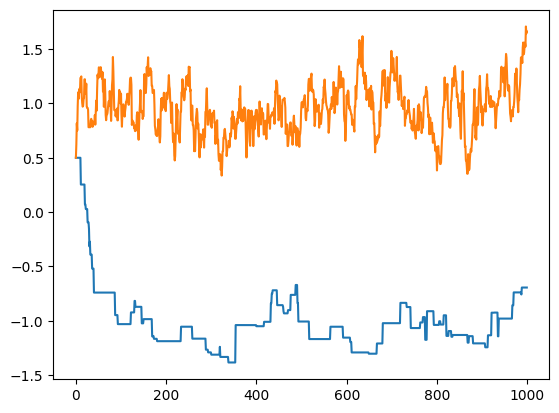

In [7]:
# plotting q values
plt.plot(qs)

##5. Create Loglikelihood Function in PyTensor

###5a. Simulate RL Q-Values

In [8]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.dvector("R") # reward vector
Q = pt.dvector("Q") # empty matrix to store q-values across trials
a = pt.scalar("a") # learning rate

# function for a single RL step
def rl_step(c, r, q_tm1):
  m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
  rm = r * m
  qm = q_tm1 * m
  return q_tm1 + a * (rm - qm)

# scan function build
Qs, updates = pytensor.scan(rl_step, sequences=[C,R], outputs_info=Q)

# Q Prediction function compilation
q_predict = pytensor.function(inputs=[C, R, Q, a], outputs=Qs)

# test values
C_test = np.random.choice(2, size = (100,)).astype(np.int32)
R_test = np.ones((100,), dtype=np.float32)
Q_test = np.zeros(shape=(2,), dtype=pytensor.config.floatX)
a_test = 0.1

# RL Model function test
q_predict(C_test,R_test,Q_test,a_test)

array([[0.1       , 0.        ],
       [0.1       , 0.1       ],
       [0.1       , 0.19      ],
       [0.19      , 0.19      ],
       [0.19      , 0.271     ],
       [0.19      , 0.3439    ],
       [0.271     , 0.3439    ],
       [0.271     , 0.40951   ],
       [0.271     , 0.468559  ],
       [0.3439    , 0.468559  ],
       [0.40951   , 0.468559  ],
       [0.40951   , 0.5217031 ],
       [0.468559  , 0.5217031 ],
       [0.5217031 , 0.5217031 ],
       [0.56953279, 0.5217031 ],
       [0.61257951, 0.5217031 ],
       [0.65132156, 0.5217031 ],
       [0.6861894 , 0.5217031 ],
       [0.6861894 , 0.56953279],
       [0.6861894 , 0.61257951],
       [0.71757046, 0.61257951],
       [0.74581342, 0.61257951],
       [0.74581342, 0.65132156],
       [0.77123208, 0.65132156],
       [0.77123208, 0.6861894 ],
       [0.79410887, 0.6861894 ],
       [0.79410887, 0.71757046],
       [0.81469798, 0.71757046],
       [0.83322818, 0.71757046],
       [0.84990536, 0.71757046],
       [0.

###5b. Calculate Loglikelihood of Simulation given parameters

####Version 1

In [91]:
# parameters & variables
C = pt.imatrix("C") # choice matrix (one-hot of choice vector)
R = pt.dmatrix("R") # reward vector
Q = pt.dvector("Q") # empty vector to store q-values across trials -> matrix of q-values
a = pt.dscalar("a") # learning rate
b = pt.dscalar("b") # RL decision temperature
ll = pt.dscalar("q_select") # empty scalar to store loglikehood values across trials -> vector of loglikelihood values

def my_ll_func(C, R, Q, a, b, ll):
    # function for a single RL step
    def rl_step(c, r, q_tm1, a):
        return q_tm1 + a * (r - q_tm1) * c

    # function to calculate loglikehood for each trial
    def ll_def(c, qs, ll, b):
        ps = pt.exp(qs/b) / pt.exp(qs/b).sum()
        p_select = (ps * c).sum()
        ll = pt.log(p_select)
        return ll

    aV = pt.ones_like((Q.shape[0])) * a
    bV = pt.ones_like((Q.shape[0])) * b

    # scan function build
    Qs, updates = pytensor.scan(rl_step, sequences=[C,R], non_sequences = [aV], outputs_info=Q)

    # scan function build
    loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], non_sequences=[bV], outputs_info=ll)

    # final output
    #loglike = loglikes.sum()
    return loglikes


output = my_ll_func(C, R, Q, a, b, ll)

loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
C_test_onehot = np.array(np.eye(n_choices)[C_test],dtype=np.int32)  # Remember to use this one
R_test = np.ones((n_trials,), dtype=np.int32) - 2 * C_test
R_test = np.repeat(R_test[:,np.newaxis],n_choices,axis=1)
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

# RL Loglikelihood function test
loglike_func(C_test_onehot,R_test,Q_test,ll_test,a_test,b_test)

array([-0.69314718, -0.91301525, -1.14367367, -0.38367367, -1.37535521,
       -1.60089159, -1.81565099, -2.01701268, -2.20377913, -2.3756893 ,
       -2.53306431, -0.08274626, -0.08274626, -2.67656635, -0.07128011,
       -0.07128011, -0.07128011, -0.07128011, -0.07128011, -2.80704098,
       -0.06228336, -2.92541656, -3.0326416 , -0.04938793, -0.04938793,
       -3.12964668, -3.21732225, -3.29650651, -3.36797964, -0.03506691,
       -3.43246216, -0.0328407 , -3.49061565, -0.03095634, -3.54304507,
       -3.5903018 , -0.02797776, -3.63288719, -3.67125627, -0.02577379,
       -0.02577379, -3.70582138, -0.02488715, -3.73695577, -3.764997  ,
       -3.79025007, -3.81299045, -3.83346679, -0.02187194, -3.85190344,
       -0.02146807, -3.86850273, -3.88344712, -3.89690109, -3.90901288,
       -0.02026423, -3.91991605, -0.02004227, -0.02004227, -3.92973097,
       -3.93856604, -0.01966828, -3.94651894, -0.01951095, -3.95367761,
       -0.01937042, -0.01937042, -0.01937042, -0.01937042, -0.01

####Version 2

In [37]:
# parameters & variables
C = pt.imatrix("C") # choice matrix (one-hot of choice vector)
R = pt.dmatrix("R") # reward vector
Q = pt.dvector("Q") # empty vector to store q-values across trials -> matrix of q-values
a = pt.dscalar("a") # learning rate
b = pt.dscalar("b") # RL decision temperature
ll = pt.dscalar("q_select") # empty scalar to store loglikehood values across trials -> vector of loglikelihood values

def my_ll_func(C, R, Q, a, b, ll):
    # function for a single RL step
    def rl_step(c, r, q_tm1, a):
        return q_tm1 + pt.mul(c,pt.mul(a,(r - q_tm1)))

    # function to calculate loglikehood for each trial
    def ll_def(c, qs, ll, b):
        ps = pt.true_div(pt.exp(pt.true_div(qs,b)),pt.exp(pt.true_div(qs,b)).sum())
        p_select = pt.mul(ps,c).sum()
        ll = pt.log(p_select)
        return ll

    aV = pt.mul(a,pt.ones_like((Q.shape[0])))
    bV = pt.mul(b,pt.ones_like((Q.shape[0])))

    # scan function build
    Qs, updates = pytensor.scan(rl_step, sequences=[C,R], non_sequences = [aV], outputs_info=Q)

    # scan function build
    loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], non_sequences=[bV], outputs_info=ll)

    # final output
    #loglike = loglikes.sum()
    return loglikes


output = my_ll_func(C, R, Q, a, b, ll)

loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)

# Test parameters
# np.random.seed(0)
# n_choices = 2
# n_trials = 100
# C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
# C_test_onehot = np.array(np.eye(n_choices)[C_test],dtype=np.int32)  # Remember to use this one
# R_test = 1 - 2*np.ones((n_trials,n_choices))
# Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
# ll_test = 0
# a_test = 0.8
# b_test = 0.5

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 10
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
C_test_onehot = np.array(np.eye(n_choices)[C_test],dtype=np.int32)  # Remember to use this one
R_test = np.ones((n_trials,), dtype=np.int32) - 2 * C_test
R_test = np.repeat(R_test[:,np.newaxis],n_choices,axis=1)
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

#print(f"CM: {C_test_onehot}\nRM: {R_test}\nQM: {Q_test}\nA: {a_test}\nB: {b_test}\nmll: ()")
#print(np.random.uniform())


# RL Loglikelihood function test
loglike_func(C_test_onehot,R_test,Q_test,ll_test,a_test,b_test)

array([-0.69314718, -0.91301525, -1.14367367, -0.38367367, -1.37535521,
       -1.60089159, -1.81565099, -2.01701268, -2.20377913, -2.3756893 ])

##7. PyMC Likelihood Modelling

##9. Hierarchical Bayes for Reinforcment Learning

###9a. Get Likelihoods from multi-participant RL data

Create Multi-participant RL data

In [10]:
class MultiRL:

  def __init__(self, n_trials: int, n_participants: int, distributions: List[Distribution]):
    self.participants: List[SimpleRL] = [
        SimpleRL(n_trials, distributions) for _ in range(n_participants)
    ]
    self.alphas = list()
    self.temperatures = list()

  def simulate(self, alpha_a, alpha_b, temperature_a, temperature_b):
    group_data = []
    for idx, participant_model in enumerate(self.participants):
      # sample participant parameters
      alpha = np.random.beta(alpha_a, alpha_b)
      temperature = np.random.beta(temperature_a, temperature_b)
      self.alphas.append(alpha)
      self.temperatures.append(temperature)
      participant_rewards, participants_choices = np.vstack(participant_model.simulate(alpha, temperature))
      assert sum(np.isnan(participant_rewards)) == 0, participant_rewards
      trial_col = np.arange(participant_model.n_trials).reshape((-1,1))
      idx_col = np.ones_like(trial_col) * idx
      group_data.append(np.concatenate([idx_col,participant_rewards.reshape((-1,1)),participants_choices.reshape((-1,1)),trial_col],axis=1))
    return np.concatenate(group_data)

  def get_params(self):
    return self.alphas, self.temperatures


In [11]:
n_trials = 100
n_participants = 5
n_choices = len(dists)
multi_rl_model = MultiRL(n_trials=n_trials,n_participants=n_participants,distributions=dists)
data = multi_rl_model.simulate(alpha_a=2.0,alpha_b=5.0,temperature_a=2.0,temperature_b=2.0)
data.shape

(500, 4)

In [36]:
# parameters & variables
CM = pt.itensor3("CM") # choice matrices OVER PARTICIPANTS
RM = pt.dtensor3("RM") # reward matrices OVER PARTICIPANTS
QM = pt.dmatrix("QM") # empty vectors to store q-values across trials OVER PARTICIPANTS
A = pt.dvector("A") # scalars of learning rates OVER PARTICIPANTS
B = pt.dvector("B") # scalars of RL decision temperatures OVER PARTICIPANTS
mll = pt.dvector("mll")  # empty scalars to store ll value OVER PARTICIPANTS

def my_mll_func(CM, RM, QM, mll, A, B):

    # function for a single RL step
    # C: vector (participants, choices)
    # R: vector (participants, choices)
    # Q_tm1: matrix (participants, choices)
    # A: vector (participants, choices)
    def rl_step(C, R, Q_tm1, A):
        return Q_tm1 + pt.mul(A,pt.mul(C,(R - Q_tm1)))

    ### function to calculate loglikehood for each trial
    # C: matrix (participants, choices)
    # Qs: matrix (participants, choices)
    # B: vector (participants, choices)
    ## Ps: matrix
    ## P_select: vector
    # mll: vector
    def ll_def(C, Qs, mll, B):
        denom = pt.exp(pt.true_div(Qs,B)).sum(axis=1)
        denom = pt.repeat(denom.reshape((denom.shape[0],1)),n_choices,axis=1)
        Ps = pt.true_div(
             pt.exp(pt.true_div(Qs,B)),
             denom
             )
        P_select = pt.mul(Ps,C).sum(axis=1)  # sum over choices
        mll = pt.log(P_select)
        return mll

    n_choices = QM.shape[1]
    A = A.reshape((A.shape[0],1))
    B = B.reshape((B.shape[0],1))
    AM = pt.repeat(A,n_choices,axis=1)
    BM = pt.repeat(B,n_choices,axis=1)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # RM: tensor3 [matrix] (trials,[participants, choices])
    # A: matrix (participants, choices)
    # QM: matrix (participants, choices) --> tensor3 (trials, participants, choices)
    QsT3, updates = pytensor.scan(rl_step, sequences=[CM,RM], non_sequences = [AM], outputs_info=QM)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # QsT3: tensor3 [matrix] (trials, [participants, choices])
    # B: matrix (participants, choices)
    # mll: scalar --> vector
    loglikes, updates = pytensor.scan(ll_def, sequences=[CM,QsT3], non_sequences=[BM], outputs_info=mll)

    return loglikes

output = my_mll_func(CM, RM, QM, mll, A, B)

mloglike_func = pytensor.function(inputs=[CM,RM,QM,mll,A,B],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 10
n_participants = 5
# CM_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,n_participants)), dtype=np.int32)
# CM_test_onehot = np.array(np.eye(n_participants,n_choices)[CM_test],dtype=np.int32)  # Remember to use this one
# RM_test = 1 - 2*np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,n_participants)))
# RM_test_repeat = np.repeat(np.expand_dims(RM_test,axis=2),n_choices,axis=2)
# QM_test = np.ones(shape=(n_participants,n_choices), dtype=pytensor.config.floatX)
mll_test = np.zeros((n_participants,))
# Compare test results to single participant
# C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
# C_test_onehot = np.array(np.eye(n_choices)[C_test],dtype=np.int32)
# R_test = 1 - 2*np.ones((n_trials,n_choices))
# Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
# a_test = 0.1
# b_test = 0.5
# ll_test = np.zeros(())
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
C_test_onehot = np.array(np.eye(n_choices)[C_test],dtype=np.int32)  # Remember to use this one
R_test = np.ones((n_trials,), dtype=np.int32) - 2 * C_test
R_test = np.repeat(R_test[:,np.newaxis],n_choices,axis=1)
a_test = 0.1
b_test = 0.5
CM_test_onehot = np.repeat(C_test_onehot[:,np.newaxis,:],n_participants,axis=1)
RM_test_repeat = np.repeat(R_test[:,np.newaxis,:],n_participants,axis=1)
QM_test = np.ones(shape=(n_participants,n_choices))
A_test = np.tile(a_test,(n_participants,))
B_test = np.tile(b_test,(n_participants,))
#CM_test_onehot = np.transpose(CM_test_onehot,(0,2,1))
#RM_test_repeat = np.transpose(RM_test_repeat,(0,2,1))
# mll_test = np.tile(ll_test,(n_participants,))
# Test parameters
#A_test = np.random.randint(low=3,high=5,size=(n_participants,)) / 10
#B_test = np.random.randint(low=6,high=9,size=(n_participants,)) / 10

# print(f"CM: {CM_test_onehot[:,0]}\nRM: {RM_test_repeat[:,0]}\nQM: {QM_test[0]}\nA: {A_test}\nB: {B_test}\nmll: ()")
# print(f"CM: {CM_test_onehot.shape}\nRM: {RM_test_repeat.shape}\nQM: {QM_test.shape}\nA: {A_test.shape}\nB: {B_test.shape}\nmll: ()")
# print(np.random.uniform())

# # RL Loglikelihood function test
mloglike_func(CM_test_onehot,RM_test_repeat,QM_test,mll_test,A_test,B_test)

array([[-0.69314718, -0.69314718, -0.69314718, -0.69314718, -0.69314718],
       [-0.91301525, -0.91301525, -0.91301525, -0.91301525, -0.91301525],
       [-1.14367367, -1.14367367, -1.14367367, -1.14367367, -1.14367367],
       [-0.38367367, -0.38367367, -0.38367367, -0.38367367, -0.38367367],
       [-1.37535521, -1.37535521, -1.37535521, -1.37535521, -1.37535521],
       [-1.60089159, -1.60089159, -1.60089159, -1.60089159, -1.60089159],
       [-1.81565099, -1.81565099, -1.81565099, -1.81565099, -1.81565099],
       [-2.01701268, -2.01701268, -2.01701268, -2.01701268, -2.01701268],
       [-2.20377913, -2.20377913, -2.20377913, -2.20377913, -2.20377913],
       [-2.3756893 , -2.3756893 , -2.3756893 , -2.3756893 , -2.3756893 ]])

In [39]:
n_trials = 400
n_participants = 20
n_choices = len(dists)
multi_rl_model = MultiRL(n_trials=n_trials,n_participants=n_participants,distributions=dists)
data = multi_rl_model.simulate(alpha_a=2.0,alpha_b=5.0,temperature_a=2.0,temperature_b=2.0)

# set up our data
df = pd.DataFrame(data=data,columns=['Participant_ID','Rewards','Choices','Trial_Num'])
participant_ids, participants = pd.factorize(df['Participant_ID'])
coords = {
    "Participant": participants,
    "obs_id": np.arange(len(participant_ids)),
}

ids = df['Participant_ID']
mll_true = np.zeros((n_participants,))
CM_true = np.zeros((n_trials,n_participants), dtype=np.int32)
RM_true = np.zeros((n_trials,n_participants))
QM_true = np.ones((n_participants,n_choices)) * 0.5
for id in range(n_participants):
    CM_true[:,id] = df.loc[df['Participant_ID'] == id, 'Choices']
    RM_true[:,id] = df.loc[df['Participant_ID'] == id, 'Rewards']

CM_true_onehot = np.array(np.eye(n_participants,n_choices)[CM_true],dtype=np.int32)  # Remember to use this one
RM_true_repeat = np.repeat(np.expand_dims(RM_true,axis=2),n_choices,axis=2)
A_true, B_true = multi_rl_model.get_params()
A_true = np.array(A_true)
B_true = np.array(B_true)
#A_true = A_test
#B_true = B_test

In [40]:
with pm.Model(coords=coords) as hierarchical_model:
    # Data
    CM = pm.ConstantData('myCM', CM_true_onehot)
    RM = pm.ConstantData('myRM', RM_true_repeat)
    QM = pm.ConstantData("myQM", QM_true)
    mll = pm.ConstantData('mll', mll_true)

    # mlogl = MultiLogLike(my_ll_func,R,C,IDs,n_ids,n_trials)

    # Hyperpriors for group nodes
    # alpha_a = pm.Gamma("alpha_a", alpha = 3. , beta = 0.5)
    # alpha_b = pm.Gamma("alpha_b", alpha = 3. , beta = 0.5)
    # beta_a = pm.Gamma("beta_a", alpha = 3. , beta = 0.5)
    # beta_b = pm.Gamma("beta_b", alpha = 3. , beta = 0.5)
    # alpha_a = pm.Uniform(name="alpha_a", lower=1.9,upper=2.1)
    # alpha_b = pm.Uniform(name="alpha_b", lower=4.9,upper=5.1)
    # beta_a = pm.Uniform(name="beta_a", lower=1.9,upper=2.1)
    # beta_b = pm.Uniform(name="beta_b", lower=1.9,upper=2.1)

    # Intercept for each participant, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_participants).
    #A = pm.Uniform(name="A",lower=alpha_a,upper=beta_a,dims="Participant")
    #B = pm.Uniform(name="B",lower=alpha_b,upper=beta_b,dims="Participant")

    # hyper_mu_A = -1
    hyper_mu_A = pm.Normal("hyper_mu_A", mu=-1, sigma=1)
    # hyper_sigma_A = 1
    hyper_sigma_A = pm.Gamma("hyper_sigma_A", alpha=5.0, beta=5.0)
    # A_prelogit = pm.Normal("A_prelogit",mu=hyper_mu_A, sigma=hyper_sigma_A,dims="Participant")
    A_prelogit = hyper_mu_A + hyper_sigma_A * pm.Normal("A_pre",mu=0, sigma=1,dims="Participant")
    A = pm.Deterministic("A", pm.math.invlogit(A_prelogit), dims="Participant")
    # post-logit: mu:0.3, sigma=~0.2

    hyper_mu_B = pm.Normal("hyper_mu_B", mu=0, sigma=1)
    hyper_sigma_B = pm.Gamma("hyper_sigma_B", alpha=5.0, beta=5.0)
    # B_prelogit = pm.Normal("B_prelogit",mu=hyper_mu_B, sigma=hyper_sigma_B,dims="Participant")
    B_prelogit = hyper_mu_B + hyper_sigma_B * pm.Normal("B_pre",mu=0, sigma=1,dims="Participant")
    B = pm.Deterministic("B", pm.math.invlogit(B_prelogit), dims="Participant")
    # post-logit: mu:0.5, sigma=~0.2

    # 1. Try Normal and Sigmoid distributions (above)
    # 2. Non centered parametrization
    # 3. Fewer trials and more subjects

    #
    # 0. Check whether non centered paramatrization helps with current settings
    # 1. Non-hierarchical many participants --> Is there still a problem with the Likelihood?
    # 2. Less variation between participants
    # 3. Even more participants

    # A = pm.Beta(name="A",alpha=alpha_a,beta=alpha_b,dims="Participant")
    # B = pm.Beta(name="B",alpha=beta_a,beta=beta_b,dims="Participant")

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", my_mll_func(CM, RM, QM, mll, A, B))
    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(3000, tune=1000, nuts_sampler="numpyro")

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [41]:
idata_mh.sample_stats.data_vars['diverging'].mean()

<xarray.DataArray 'diverging' ()>
array(0.)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'hyper_mu_A'}>,
        <Axes: title={'center': 'hyper_mu_A'}>],
       [<Axes: title={'center': 'A_pre'}>,
        <Axes: title={'center': 'A_pre'}>],
       [<Axes: title={'center': 'hyper_mu_B'}>,
        <Axes: title={'center': 'hyper_mu_B'}>],
       [<Axes: title={'center': 'B_pre'}>,
        <Axes: title={'center': 'B_pre'}>],
       [<Axes: title={'center': 'hyper_sigma_A'}>,
        <Axes: title={'center': 'hyper_sigma_A'}>],
       [<Axes: title={'center': 'hyper_sigma_B'}>,
        <Axes: title={'center': 'hyper_sigma_B'}>],
       [<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'B'}>]],
      dtype=object)

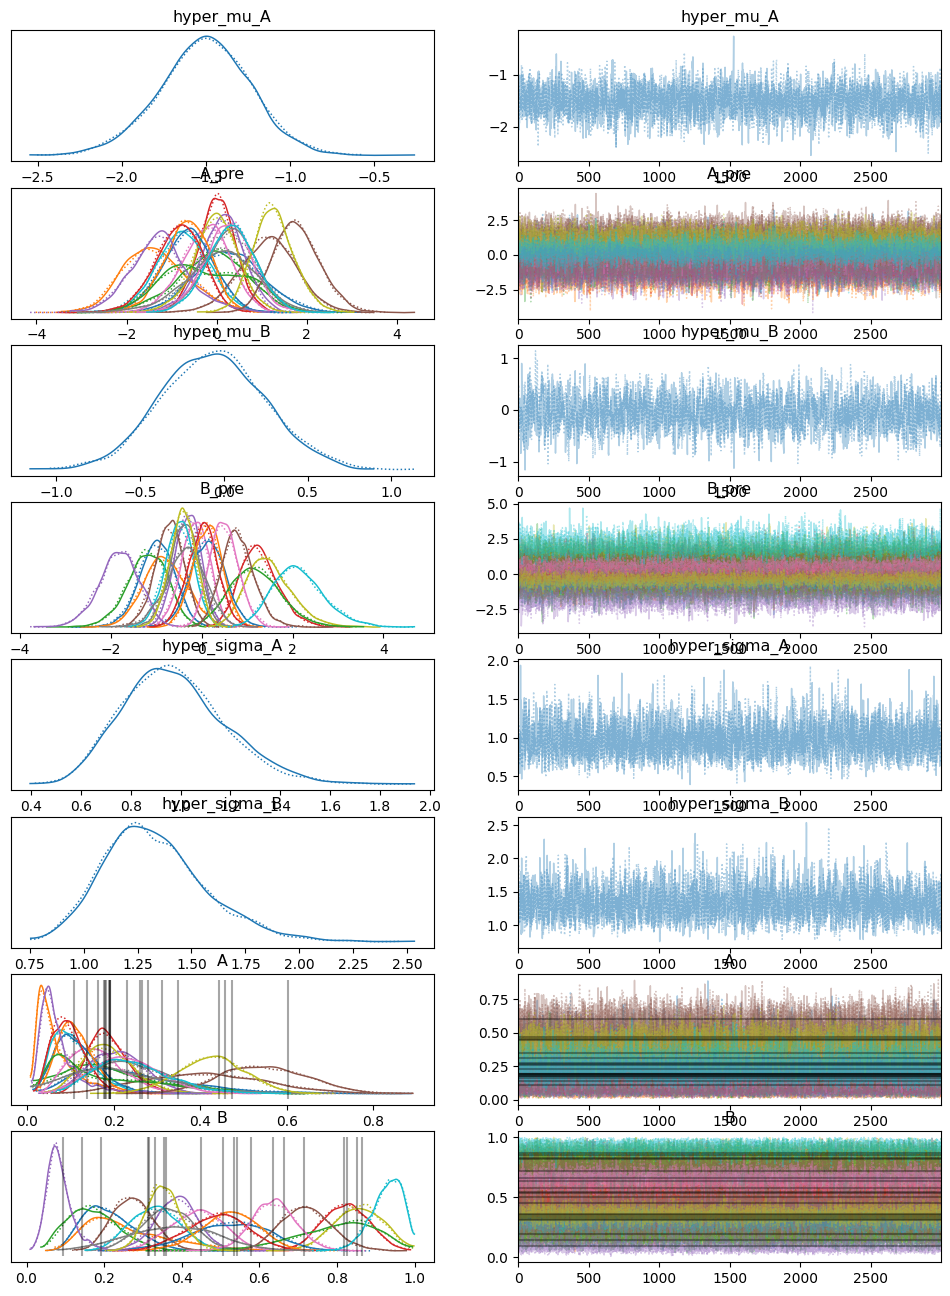

In [42]:
az.plot_trace(idata_mh, lines=[
    ("A", {}, A_true),
    ("B", {}, B_true),
      ])

###Trash

In [21]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.dvector("R") # reward vector
Q = pt.dvector("Q") # empty vector to store q-values across trials -> matrix of q-values
a = pt.dscalar("a") # learning rate
b = pt.dscalar("b") # RL decision temperature
ll = pt.dscalar("q_select") # empty scalar to store loglikehood values across trials -> vector of loglikelihood values

def my_ll_func(C, R, Q, a, b, ll):
    # function for a single RL step
    def rl_step(c, r, q_tm1, a):
        m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
        rm = r * m
        qm = q_tm1 * m
        return q_tm1 + a * (rm - qm)

    # function to calculate loglikehood for each trial
    def ll_def(c, qs, ll, b):
        mask = pt.set_subtensor(pt.zeros_like(qs)[c], pt.constant(1))
        ps = pt.exp(qs/b) / pt.exp(qs/b).sum()
        p_select = (ps * mask).sum()
        ll = pt.log(p_select)
        return ll

    # scan function build
    Qs, updates = pytensor.scan(rl_step, sequences=[C,R], non_sequences = [a], outputs_info=Q)

    # scan function build
    loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], non_sequences=[b], outputs_info=ll)

    # final output
    #loglike = loglikes.sum()
    return loglikes


#ll_func = make_ll_func(C,R,Q,ll)
output = my_ll_func(C, R, Q, a, b, ll)
# output = ll_func(a,b)

# loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)
loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
R_test = np.ones((n_trials,), dtype=np.int32) * C_test
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

# RL Loglikelihood function test
loglike_func(C_test,R_test,Q_test,ll_test,a_test,b_test)

array([-0.79813887, -0.59813887, -0.59813887, -0.90108961, -0.52108961,
       -0.52108961, -0.52108961, -0.52108961, -0.52108961, -0.52108961,
       -0.52108961, -1.00042683, -1.09505068, -0.40725068, -1.18426258,
       -1.26768372, -1.34517814, -1.41678671, -1.48267385, -0.25751482,
       -1.5430861 , -0.24044298, -0.24044298, -1.598321  , -1.64870418,
       -0.21356325, -0.21356325, -0.21356325, -0.21356325, -1.69457283,
       -0.20294599, -1.73626415, -0.1938    , -1.77410741, -0.18588967,
       -0.18588967, -1.80841872, -0.17902275, -0.17902275, -1.83949777,
       -1.867626  , -0.16781527, -1.89306575, -0.16323609, -0.16323609,
       -0.16323609, -0.16323609, -0.16323609, -1.91606016, -0.15921347,
       -1.93683352, -0.15567149, -0.15567149, -0.15567149, -0.15567149,
       -1.95559194, -0.15254612, -1.97252429, -1.98780313, -0.14733602,
       -0.14733602, -2.00158587, -0.14516547, -2.01401578, -0.14323741,
       -2.02522308, -2.03532601, -2.04443179, -2.05263755, -2.06

In [22]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.dvector("R") # reward vector
Q = pt.dvector("Q") # empty vector to store q-values across trials -> matrix of q-values
a = pt.dscalar("a") # learning rate
b = pt.dscalar("b") # RL decision temperature
ll = pt.dscalar("q_select") # empty scalar to store loglikehood values across trials -> vector of loglikelihood values

def my_ll_func(C, R, Q, ll, a, b):

    # function for a single RL step
    def rl_step(c, r, q_tm1, a):
        m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
        rm = r * m
        qm = q_tm1 * m
        return q_tm1 + a * (rm - qm)

    # function to calculate loglikehood for each trial
    def ll_def(c, qs, ll, b):
        mask = pt.set_subtensor(pt.zeros_like(qs)[c], pt.constant(1))
        ps = pt.exp(qs/b) / pt.exp(qs/b).sum()
        p_select = (ps * mask).sum()
        ll = pt.log(p_select)
        return ll

    # scan function build
    Qs, updates = pytensor.scan(rl_step, sequences=[C,R], non_sequences = [a], outputs_info=Q)

    # scan function build
    loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], non_sequences=[b], outputs_info=ll)

    # final output
    #loglike = loglikes.sum()
    return loglikes


#ll_func = make_ll_func(C,R,Q,ll)
output = my_ll_func(C, R, Q, ll, a, b)
# output = ll_func(a,b)

# loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)
loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
R_test = np.ones((n_trials,), dtype=np.int32) * C_test
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

print(f"{C_test.shape}\n{R_test.shape}\n{Q_test.shape}\n()\n()\n()")

# RL Loglikelihood function test
loglike_func(C_test,R_test,Q_test,ll_test,a_test,b_test)

(100,)
(100,)
(2,)
()
()
()


array([-0.79813887, -0.59813887, -0.59813887, -0.90108961, -0.52108961,
       -0.52108961, -0.52108961, -0.52108961, -0.52108961, -0.52108961,
       -0.52108961, -1.00042683, -1.09505068, -0.40725068, -1.18426258,
       -1.26768372, -1.34517814, -1.41678671, -1.48267385, -0.25751482,
       -1.5430861 , -0.24044298, -0.24044298, -1.598321  , -1.64870418,
       -0.21356325, -0.21356325, -0.21356325, -0.21356325, -1.69457283,
       -0.20294599, -1.73626415, -0.1938    , -1.77410741, -0.18588967,
       -0.18588967, -1.80841872, -0.17902275, -0.17902275, -1.83949777,
       -1.867626  , -0.16781527, -1.89306575, -0.16323609, -0.16323609,
       -0.16323609, -0.16323609, -0.16323609, -1.91606016, -0.15921347,
       -1.93683352, -0.15567149, -0.15567149, -0.15567149, -0.15567149,
       -1.95559194, -0.15254612, -1.97252429, -1.98780313, -0.14733602,
       -0.14733602, -2.00158587, -0.14516547, -2.01401578, -0.14323741,
       -2.02522308, -2.03532601, -2.04443179, -2.05263755, -2.06

In [ ]:
# define a pytensor Op for our likelihood function
class MultiLogLike(pt.Op):

    itypes = [pt.dmatrix]  # expects a matrix of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, r, c, ids, n_ids, n_trials):
        # add inputs as class attributes
        self.likelihood = loglike
        self.R = r
        self.C = c
        self.ids = ids
        self.n_ids = n_ids
        self.n_trials = n_trials

    def perform(self, node, inputs, outputs):
      (theta,) = inputs  # this will contain my variables
      total = 0
      # total = np.zeros((len(self.ids.unique())))
      # for i, id in enumerate(self.unique_ids):
      #  id_index = self.ids[self.ids == id]
      for i in range(self.n_ids):
        r = self.R[i*self.n_trials:(i+1)*self.n_trials]
        c = self.C[i*self.n_trials:(i+1)*self.n_trials]
        a = theta[0][i]
        b = theta[1][i]
        total += self.likelihood(a,b, r, c)
      outputs[0][0] = np.array(total)

In [52]:
# define a pytensor Op for our likelihood function
class LogLike(pt.Op):

    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dvector]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, c, r):
        # add inputs as class attributes
        self.likelihood = loglike
        self.C = c
        self.R = r

    def perform(self, node, inputs, outputs):
      (theta,) = inputs  # this will contain my variables
      outputs[0][0] = self.likelihood(theta[0], theta[1])



In [61]:
# parameters & variables
C = pt.ivector("C") # choice vector
R = pt.dvector("R") # reward vector
Q = pt.dvector("Q") # empty vector to store q-values across trials -> matrix of q-values
a = pt.dscalar("a") # learning rate
b = pt.dscalar("b") # RL decision temperature
ll = pt.dscalar("q_select") # empty scalar to store loglikehood values across trials -> vector of loglikelihood values

def my_ll_func(C, R, Q, a, b, ll):
    # function for a single RL step
    def rl_step(c, r, q_tm1, a):
        m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
        rm = r * m
        qm = q_tm1 * m
        return q_tm1 + a * (rm - qm)

    # function to calculate loglikehood for each trial
    def ll_def(c, qs, ll, b):
        mask = pt.set_subtensor(pt.zeros_like(qs)[c], pt.constant(1))
        ps = pt.exp(qs/b) / pt.exp(qs/b).sum()
        p_select = (ps * mask).sum()
        ll = pt.log(p_select)
        return ll

    # scan function build
    Qs, updates = pytensor.scan(rl_step, sequences=[C,R], non_sequences = [a], outputs_info=Q)

    # scan function build
    loglikes, updates = pytensor.scan(ll_def, sequences=[C,Qs], non_sequences=[b], outputs_info=ll)

    # final output
    #loglike = loglikes.sum()
    return loglikes


#ll_func = make_ll_func(C,R,Q,ll)
output = my_ll_func(C, R, Q, a, b, ll)
# output = ll_func(a,b)

# loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)
loglike_func = pytensor.function(inputs=[C,R,Q,ll,a,b],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
R_test = np.ones((n_trials,), dtype=np.int32) - 2*C_test
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

# RL Loglikelihood function test
loglike_func(C_test,R_test,Q_test,ll_test,a_test,b_test)

array([-0.69314718, -0.91301525, -1.14367367, -0.38367367, -1.37535521,
       -1.60089159, -1.81565099, -2.01701268, -2.20377913, -2.3756893 ,
       -2.53306431, -0.08274626, -0.08274626, -2.67656635, -0.07128011,
       -0.07128011, -0.07128011, -0.07128011, -0.07128011, -2.80704098,
       -0.06228336, -2.92541656, -3.0326416 , -0.04938793, -0.04938793,
       -3.12964668, -3.21732225, -3.29650651, -3.36797964, -0.03506691,
       -3.43246216, -0.0328407 , -3.49061565, -0.03095634, -3.54304507,
       -3.5903018 , -0.02797776, -3.63288719, -3.67125627, -0.02577379,
       -0.02577379, -3.70582138, -0.02488715, -3.73695577, -3.764997  ,
       -3.79025007, -3.81299045, -3.83346679, -0.02187194, -3.85190344,
       -0.02146807, -3.86850273, -3.88344712, -3.89690109, -3.90901288,
       -0.02026423, -3.91991605, -0.02004227, -0.02004227, -3.92973097,
       -3.93856604, -0.01966828, -3.94651894, -0.01951095, -3.95367761,
       -0.01937042, -0.01937042, -0.01937042, -0.01937042, -0.01

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/traceplot.py:217: UserWarning: A valid var_name should be provided, found {'b_true', 'a_true'} expected from {'a', 'b'}
  warnings.warn(


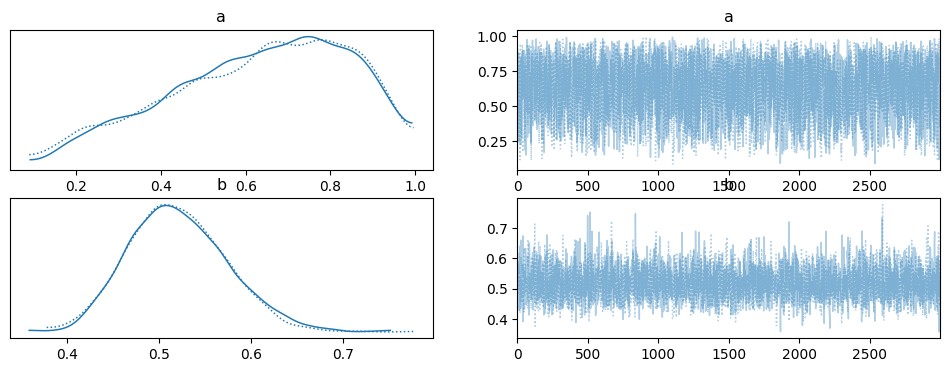

In [68]:
# Creating Ground Truth Data
n_trials = 250
mean_rewards = [-0.5,0.5]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":0.2}) for mn in mean_rewards]
rl_model = SimpleRL(n_trials=n_trials,distributions=dists)

np.random.seed(0)
n_choices = 2
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
C_test_onehot = np.array(np.eye(n_choices)[C_test],dtype=np.int32)  # Remember to use this one
R_test = np.ones((n_trials,), dtype=np.int32) - 2 * C_test
R_test = np.repeat(R_test[:,np.newaxis],n_choices,axis=1)
Q_test = np.ones(shape=(n_choices,), dtype=pytensor.config.floatX)
ll_test = 0
a_test = 0.1
b_test = 0.5

a_true = 0.8
b_true = 0.5
R_true, C_true = rl_model.simulate(a_true,b_true)
Qs_true = np.ones((2,)) * 0.5
ll_true = 0
R_true = np.repeat(R_true[:,np.newaxis],n_choices,axis=1)
C_true_onehot = np.array(np.eye(n_choices)[C_true],dtype=np.int32)  # Remember to use this one

# use PyMC to sampler from log-likelihood
with pm.Model():
    # Data
    C = pm.ConstantData('myC', C_true_onehot)
    R = pm.ConstantData('myR', R_true)
    Q = pm.ConstantData("myQ", Qs_true)
    ll_true = pm.ConstantData('ll_true', ll_true)

    # Priors
    a = pm.Beta(name="a",alpha=2,beta=2)
    b = pm.Beta(name="b",alpha=2,beta=2)
    # a = pm.LogNormal(name="a", sigma=1.0)
    # b = pm.LogNormal(name="b", sigma=2.0)

    # convert m and c to a tensor vector

    # rl_likelihoods = pm.RLModel("name", *params, observed = (C, R))

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", my_ll_func(C, R, Q, a, b, ll_true))
    #pm.Potential("likelihood", logl(theta))

    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(3000, tune=1000, nuts_sampler="numpyro")

# plot the traces
az.plot_trace(idata_mh, lines=[("a_true", {}, a_true), ("b_true", {}, b_true)]);

In [ ]:
# parameters & variables
CM = pt.imatrix("CM") # choice vectors OVER PARTICIPANTS
RM = pt.dmatrix("RM") # reward vectors OVER PARTICIPANTS
QM = pt.dmatrix("QM") # empty matrix to store q-values across trials OVER PARTICIPANTS
A = pt.dmatrix("A") # vectors of learning rates OVER PARTICIPANTS
B = pt.dmatrix("B") # vectors of RL decision temperatures OVER PARTICIPANTS
llV = pt.dvector("llV")  # empty scalars to store ll value OVER PARTICIPANTS

def my_llV_func(CM, RM, QM, llV, A, B):
    # make mask function for multi-participant

    # c: scalar
    # ms: vector (choices)
    def mask_step(c,ms):
        # m = pt.set_subtensor(pt.zeros_like(q)[c], pt.constant(1))
        ms = pt.set_subtensor(ms[c], pt.constant(1))
        return ms

    # C: vector (participants)
    # Q: matrix (participants,choices)
    ## M: matrix (choices,participants)
    def make_mask(C,Q):
        # ms = pt.zeros((Q.shape[1]))  # This line doesn't seem to work
        ms = pt.zeros((Q.shape[1]))
        # ms = pt.dvector("ms")
        M, updates = pytensor.scan(mask_step, sequences=[C], outputs_info=ms)
        return M

    # function for a single RL step
    # C: vector (participants)
    # R: vector (participants)
    # Q_tm1: matrix (participants, choices)
    # A: vector (participants)
    ## M: matrix ()
    def rl_step(C, R, A, Q_tm1):
        # m = pt.set_subtensor(pt.zeros_like(q_tm1)[c], pt.constant(1))
        M = make_mask(C,Q_tm1)
        # M = M.reshape((M.shape[1],M.shape[0]))
        # R = pt.matmul(pt.ones((Q_tm1.shape[1],1)),R.reshape((1,R.shape[0])))
        R = pt.matmul(R.reshape((R.shape[0],1)),pt.ones((1,Q_tm1.shape[1])))  # Reshaping rewards to have same dimensionality as Q-values (participants,choices)
        Rm = pt.mul(R,M)
        # Rm = R * M
        Qm = pt.mul(Q_tm1,M)
        # Qm = Q_tm1 * M
        return Q_tm1 + pt.mul(A,(Rm - Qm))

    ### function to calculate loglikehood for each trial
    # C: vector (participants)
    # Qs: matrix (participants, choices)
    # B: vector (participants)
    ## Ps: matrix
    ## M: matrix
    ## P_select: vector
    # llV: vector
    def ll_def(C, Qs, llV, B):
        # mask = pt.set_subtensor(pt.zeros_like(qs)[c], pt.constant(1))
        M = make_mask(C,Qs)
        denom = pt.exp(pt.true_div(Qs,B)).sum(axis=1)
        denom = pt.matmul(denom.reshape((denom.shape[0],1)),pt.ones((1,Qs.shape[1])))  # Reshaping denominator to have same dimensionality as numerator (participants,choices)
        Ps = pt.true_div(
            pt.exp(pt.true_div(Qs,B)),
            denom
            )
        P_select = pt.mul(Ps,M).sum(axis=1)
        llV = pt.log(P_select)
        return llV

    ### scan function
    # CM: matrix [vector] (trials,[participants])
    # RM: matrix [vector] (trials,[participants])
    # A: matrix (participants, choices)
    ## M: matrix ()
    # QM: matrix (participants, choices) --> tensor3
    QsT3, updates = pytensor.scan(rl_step, sequences=[CM,RM], non_sequences = [A], outputs_info=QM)

    # d0, d1, d2 = QsT3.shape
    # QsT3 = QsT3.reshape((d1,d0,d2))

    ### scan function
    # CM: matrix [vector] (trials,[participants])
    # QsT3: tensor3 [matrix]
    # B: vector
    ## M: matrix
    # llV: vector --> matrix
    loglikes, updates = pytensor.scan(ll_def, sequences=[CM,QsT3], non_sequences=[B], outputs_info=llV)

    # final output
    # loglike = loglikes.sum()
    return loglikes

output = my_llV_func(CM, RM, QM, llV, A, B)
# output = my_mll_func(CM, RM, QM, A, B)

loglike_func = pytensor.function(inputs=[CM,RM,QM,llV,A,B],outputs=output)
# loglike_func = pytensor.function(inputs=[CM,RM,QM,A,B],outputs=output)

# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 100
n_participants = 5
CM_test = np.array([np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32) for _ in range(n_participants)])
RM_test = np.array([np.ones((n_trials,), dtype=np.int32) for _ in range(n_participants)]) * C_test
QM_test = np.array([np.ones(shape=(n_choices,), dtype=pytensor.config.floatX) for _ in range(n_participants)])
llV_test = np.zeros((n_participants,))
A_test = np.random.randint(low=3,high=5,size=(n_participants,n_choices)) / 10
B_test = np.random.randint(low=6,high=9,size=(n_participants,n_choices)) / 10

# # (uncomment / comment) these lines to make it (work but produce nans / not work)
CM_test = CM_test.transpose((1,0))  #.reshape((CM_test.shape[1],-1,CM_test.shape[0]))
RM_test = RM_test.transpose((1,0))  #.reshape((RM_test.shape[1],-1,RM_test.shape[0]))
#QM_test = QM_test.transpose((1,0))  #.reshape((QM_test.shape[1],-1,QM_test.shape[0]))
#A_test = A_test.transpose((1,0))
#B_test = B_test.transpose((1,0))

print(f"CM: {CM_test.shape}\nRM: {RM_test.shape}\nQM: {QM_test.shape}\nA: {A_test.shape}\nB: {B_test.shape}\nllV: {llV_test.shape}")
# print(f"{CM_test.shape}\n{RM_test.shape}\n{QM_test.shape}\n{A_test.shape}")

# # RL Loglikelihood function test
loglike_func(CM_test,RM_test,QM_test,llV_test,A_test,B_test)
# loglike_func(CM_test,RM_test,QM_test,A_test,B_test)

In [ ]:
def fit_pymc(R,C,priors):
  # create our Op
  logl = LogLike(loglike_func, R, C)
  # use PyMC to sampler from log-likelihood
  with pm.Model():
      # uniform priors on m and c
      prior_dists, prior_args = priors
      a = prior_dists[0](*prior_args[0])
      b = prior_dists[1](*prior_args[1])
      # convert m and c to a tensor vector
      theta = pt.as_tensor_variable([a, b])
      # use a Potential to "call" the Op and include it in the logp computation
      pm.Potential("likelihood", logl(theta))
      # Use custom number of draws to replace the HMC based defaults
      idata_mh = pm.sample(3000, tune=1000, nuts_sampler="numpyro")
  return idata_mh

In [ ]:
# Calibration Parameters
nrep = 10
trials = 500
a_range = (0.01,0.99)
b_range = (0.01,0.99)
mean_rewards = [-0.3,0.7]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]
prior_dist = (pm.Uniform, pm.Uniform)
prior_args = (["a", 1e-4, 1e-0],
              ["b", 1e-4, 1e+0])  # alpha=1, beta=1; alpha=10 beta=10
priors = (prior_dist, prior_args)
# Calibrator Functions
def sample(n_trials,dists,a,b):
  return SimpleRL(n_trials=n_trials,distributions=dists).simulate(alpha=a,temperature=b)

In [ ]:
# quantiles = np.zeros((nrep,2))
# for rep_i in tqdm(range(nrep)):
#   a_true = np.random.uniform(*a_range)
#   b_true = np.random.uniform(*b_range)
#   y_R, y_C = sample(trials,dists,a_true,b_true)
#   data = fit_pymc(y_R, y_C, priors)
#   quantiles[rep_i,0] = np.mean(data.posterior.a > a_true)
#   quantiles[rep_i,1] = np.mean(data.posterior.b > b_true)
#   az.plot_trace(data, lines=[("m", {}, a_true), ("c", {}, b_true)])

####Version 1

Wrapping model into PyMC using pm potential

Code was taken from PyMC documentation and modified

In [ ]:
# Creating Ground Truth Data
n_trials = 1000
mean_rewards = [-0.5,0.5]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":0.2}) for mn in mean_rewards]
rl_model = SimpleRL(n_trials=n_trials,distributions=dists)
n_choices = len(dists)

a_true = 0.1
b_true = 0.5
R_true, C_true = rl_model.simulate(a_true,b_true)
C_true_onehot = np.array(np.eye(n_choices)[C_true],dtype=np.int32)
R_true_onehot = np.repeat(np.expand_dims(R_true,axis=1),n_choices,axis=1)
Qs_true = np.ones((n_choices,)) * 0.5
ll_true = 0

In [ ]:
# use PyMC to sampler from log-likelihood
with pm.Model():
    # Data
    C = pm.ConstantData('myC', C_true_onehot)
    R = pm.ConstantData('myR', R_true_onehot)
    Q = pm.ConstantData("myQ", Qs_true)
    ll_true = pm.ConstantData('ll_true', ll_true)

    # Priors
    a = pm.Beta(name="a",alpha=1,beta=5)
    b = pm.Beta(name="b",alpha=2,beta=2)
    # a = pm.LogNormal(name="a", sigma=1.0)
    # b = pm.LogNormal(name="b", sigma=2.0)

    # convert m and c to a tensor vector

    # rl_likelihoods = pm.RLModel("name", *params, observed = (C, R))

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", my_ll_func(C, R, Q, a, b, ll_true))
    #pm.Potential("likelihood", logl(theta))

    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(5000, tune=1000, nuts_sampler="numpyro")

# plot the traces
az.plot_trace(idata_mh, lines=[("a", {}, a_true), ("b", {}, b_true)]);

In [ ]:
az.plot_pair(idata_mh, kind="kde")